Train: {'fractured': 4606, 'not fractured': 4640}
Validation: {'fractured': 337, 'not fractured': 492}
Test: {'fractured': 238, 'not fractured': 268}


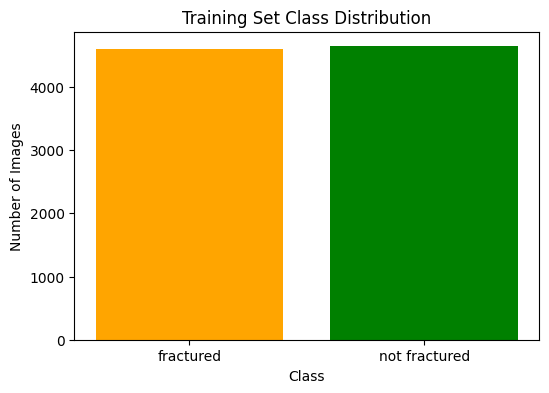

Computed Class Weights: {0: np.float64(1.0036908380373426), 1: np.float64(0.9963362068965518)}
✅ Preprocessing complete — class weights saved as class_weights.json


In [4]:
# 1_Preprocessing_and_Balancing.ipynb

# --- Step 1: Import Libraries ---
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import json

# --- Step 2: Define Dataset Paths ---
#task = "Bone_Fracture_Detection"   

base_dir = f"../Datasets/Bone_Fracture_Detection"
#base_dir = 'Fracture_Dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

classes = ['fractured', 'not fractured']

# --- Step 3: Count Images per Class ---
def count_images_in_subfolders(directory):
    counts = {}
    for cls in classes:
        cls_dir = os.path.join(directory, cls)
        counts[cls] = len(os.listdir(cls_dir))
    return counts

train_counts = count_images_in_subfolders(train_dir)
val_counts = count_images_in_subfolders(val_dir)
test_counts = count_images_in_subfolders(test_dir)

print("Train:", train_counts)
print("Validation:", val_counts)
print("Test:", test_counts)

# --- Step 4: Visualize Dataset Balance ---
plt.figure(figsize=(6,4))
plt.bar(train_counts.keys(), train_counts.values(), color=['orange','green'])
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# --- Step 5: Compute Class Weights ---
fractured_count = train_counts['fractured']
nonfractured_count = train_counts['not fractured']

y_train = np.array([0]*fractured_count + [1]*nonfractured_count)
weights = class_weight.compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weights = {0: weights[0], 1: weights[1]}

print("Computed Class Weights:", class_weights)

# --- Step 6: Save Class Weights for Later Use ---
with open("class_weights.json", "w") as f:
    json.dump(class_weights, f)

print("✅ Preprocessing complete — class weights saved as class_weights.json")


In [6]:
# ============================================================
# 📘 NOTEBOOK 2: Model Training & Evaluation
# Project: Bone Fracture Detection (Fracture vs Non-Fracture)
# ============================================================

# --- Step 1: Imports ---
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import json
import os

# ✅ Handle corrupted or truncated images safely
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# --- Step 2: Paths ---
base_dir = "../Datasets/Bone_Fracture_Detection"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


# --- Step 3: Load Class Weights from Preprocessing ---
with open("class_weights.json", "r") as f:
    class_weights = json.load(f)
print("Loaded Class Weights:", class_weights)


Loaded Class Weights: {'0': 1.0036908380373426, '1': 0.9963362068965518}


In [7]:
# --- Step 4: Image Data Generators ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 9246 images belonging to 2 classes.
Found 829 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [8]:

# --- Step 5: Build Model (MobileNetV2) ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False  # Freeze pre-trained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


# --- Step 6: Callbacks ---
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-6, 
    verbose=1
)


# --- Step 7: Train Model ---
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler]
)




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 847ms/step - accuracy: 0.6383 - loss: 0.6496  

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 271s 923ms/step - accuracy: 0.6940 - loss: 0.5790 - val_accuracy: 0.8263 - val_loss: 0.3954 - learning_rate: 1.0000e-04
Epoch 2/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 191s 660ms/step - accuracy: 0.7869 - loss: 0.4567 - val_accuracy: 0.8625 - val_loss: 0.3557 - learning_rate: 1.0000e-04
Epoch 3/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 190s 657ms/step - accuracy: 0.8111 - loss: 0.4197 - val_accuracy: 0.8733 - val_loss: 0.3097 - learning_rate: 1.0000e-04
Epoch 4/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 190s 657ms/step - accuracy: 0.8350 - loss: 0.3780 - val_accuracy: 0.8830 - val_loss: 0.2983 - learning_rate: 1.0000e-04
Epoch 5/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 191s 659ms/step - accuracy: 0.8472 - loss: 0.3575 - val_accuracy: 0.8818 - val_loss: 0.2922 - learning_rate: 1.0000e-04
Epoch 6/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 192s 665ms/step - accuracy: 0.8612 - loss: 0.3288 - val_accuracy: 0.8999 - val_loss: 0.2689 - learning_rate: 1.0000e-04
Epoch 7/20
289/289 ━━━━━━━━━━━━━━━━━━━━ 207s 683ms/

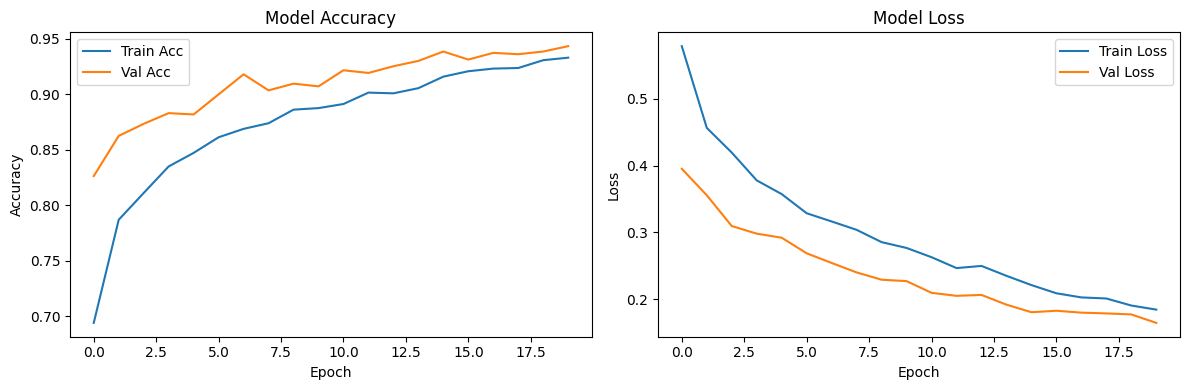

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 884ms/step - accuracy: 0.9486 - loss: 0.1613

✅ Test Accuracy: 0.9486
✅ Test Loss: 0.1613
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 618ms/step


In [9]:
# --- Step 8: Training Curves ---
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# --- Step 9: Evaluation on Test Set ---
test_loss, test_acc = model.evaluate(test_data)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# --- Step 10: Predictions ---
predictions = model.predict(test_data)
pred_labels = (predictions > 0.5).astype(int).flatten()
true_labels = test_data.classes





Classification Report:

               precision    recall  f1-score   support

    Fractured       0.92      0.97      0.95       238
Non-Fractured       0.97      0.93      0.95       268

     accuracy                           0.95       506
    macro avg       0.95      0.95      0.95       506
 weighted avg       0.95      0.95      0.95       506



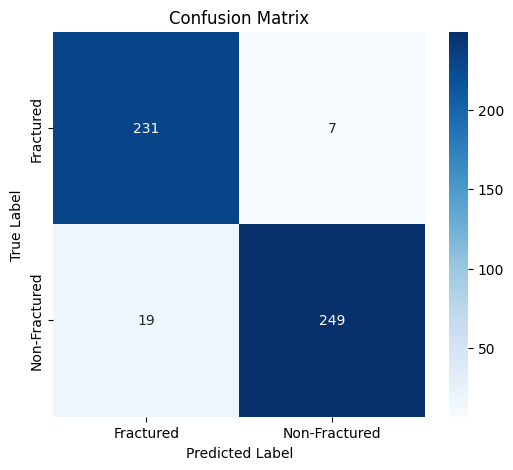


💾 Model saved as 'fracture_detection_mobilenetv2.h5'


In [12]:
# --- Step 11: Classification Report ---
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=['Fractured', 'Non-Fractured']))


# --- Step 12: Confusion Matrix ---
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fractured', 'Non-Fractured'], yticklabels=['Fractured', 'Non-Fractured'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# --- Step 13: Save the Model ---
model.save("fracture_detection_mobilenetv2.h5")
print("\n💾 Model saved as 'fracture_detection_mobilenetv2.h5'")

In [20]:
import os
import shutil
from tqdm import tqdm

# ----------------------
# Paths (use full absolute paths to avoid relative path issues)
# ----------------------
fracture_dataset = r"C:/Users/lenovo/Desktop/FractureNet+/Datasets/Bone_Fracture_Detection"
fragility_dataset = r"C:/Users/lenovo/Desktop/FractureNet+/Datasets/FragilityLevelDetection"
integrated_dataset = r"C:/Users/lenovo/Desktop/FractureNet+/Datasets/integrated_dataset"

# ----------------------
# Splits
# ----------------------
fracture_splits = ["train", "val", "test"]
fragility_splits = ["train", "test"]

# ----------------------
# Helper function: sanitize folder names (remove trailing spaces)
# ----------------------
def clean_folder_name(name):
    return name.strip()

# ----------------------
# Detect fracture classes
# ----------------------
fracture_classes = []
for split in fracture_splits:
    split_path = os.path.join(fracture_dataset, split)
    if os.path.exists(split_path):
        fracture_classes = [clean_folder_name(d) for d in os.listdir(split_path)
                            if os.path.isdir(os.path.join(split_path, d))]
        break
if not fracture_classes:
    fracture_classes = ["fractured", "not fractured"]  # fallback

# Detect fragility classes
fragility_classes = []
for split in fragility_splits:
    split_path = os.path.join(fragility_dataset, split)
    if os.path.exists(split_path):
        fragility_classes = [clean_folder_name(d) for d in os.listdir(split_path)
                             if os.path.isdir(os.path.join(split_path, d))]
        break
if not fragility_classes:
    fragility_classes = ["Normal", "Osteopenia", "Osteoporosis"]  # fallback

print("Fracture classes detected:", fracture_classes)
print("Fragility classes detected:", fragility_classes)

# ----------------------
# Step 1: Copy fracture images
# ----------------------
for split in fracture_splits:
    for cls in fracture_classes:
        src_folder = os.path.join(fracture_dataset, split, cls)
        dst_folder = os.path.join(integrated_dataset, split, cls)
        os.makedirs(dst_folder, exist_ok=True)

        if not os.path.exists(src_folder):
            print(f"Warning: {src_folder} does not exist, skipping...")
            continue

        images = os.listdir(src_folder)
        print(f"Copying {len(images)} fracture images from {split}/{cls}...")
        for img_file in tqdm(images, desc=f"Fracture {cls} {split}"):
            src_path = os.path.join(src_folder, img_file)
            dst_path = os.path.join(dst_folder, img_file)
            if os.path.exists(dst_path):
                dst_path = os.path.join(dst_folder, f"{cls}_{img_file}")
            shutil.copy2(src_path, dst_path)

# ----------------------
# Step 2: Copy fragility images into not_fractured folder
# ----------------------
for split in fragility_splits:
    dst_split_folder = os.path.join(integrated_dataset, split, "not fractured")
    os.makedirs(dst_split_folder, exist_ok=True)

    print(f"\nAdding fragility images from {split} to integrated not_fractured folder...")
    for cls in fragility_classes:
        src_class_folder = os.path.join(fragility_dataset, split, cls)
        if not os.path.exists(src_class_folder):
            print(f"Warning: {src_class_folder} does not exist, skipping...")
            continue

        images = os.listdir(src_class_folder)
        print(f"Copying {len(images)} {cls} images...")
        for img_file in tqdm(images, desc=f"{cls} {split}"):
            src_path = os.path.join(src_class_folder, img_file)
            dst_path = os.path.join(dst_split_folder, img_file)
            if os.path.exists(dst_path):
                dst_path = os.path.join(dst_split_folder, f"{cls}_{img_file}")
            shutil.copy2(src_path, dst_path)

# ----------------------
# Step 3: Summary of image counts
# ----------------------
print("\nIntegrated dataset created successfully at:", integrated_dataset)
for split in fracture_splits:
    for cls in fracture_classes:
        folder = os.path.join(integrated_dataset, split, cls)
        count = len(os.listdir(folder)) if os.path.exists(folder) else 0
        print(f"{split}/{cls}: {count} images")
for split in fragility_splits:
    folder = os.path.join(integrated_dataset, split, "not fractured")
    count = len(os.listdir(folder)) if os.path.exists(folder) else 0
    print(f"{split}/not_fractured: {count} images")


Fracture classes detected: ['fractured', 'not fractured']
Fragility classes detected: ['Normal', 'Osteopenia', 'Osteoporosis']
Copying 4606 fracture images from train/fractured...


Fracture fractured train: 100%|████████████████████████████████████████████████████| 4606/4606 [00:53<00:00, 85.79it/s]


Copying 4640 fracture images from train/not fractured...


Fracture not fractured train: 100%|████████████████████████████████████████████████| 4640/4640 [00:49<00:00, 94.37it/s]


Copying 337 fracture images from val/fractured...


Fracture fractured val: 100%|████████████████████████████████████████████████████████| 337/337 [00:03<00:00, 93.84it/s]


Copying 492 fracture images from val/not fractured...


Fracture not fractured val: 100%|████████████████████████████████████████████████████| 492/492 [00:05<00:00, 86.64it/s]


Copying 238 fracture images from test/fractured...


Fracture fractured test: 100%|███████████████████████████████████████████████████████| 238/238 [00:02<00:00, 82.11it/s]


Copying 268 fracture images from test/not fractured...


Fracture not fractured test: 100%|███████████████████████████████████████████████████| 268/268 [00:03<00:00, 82.56it/s]



Adding fragility images from train to integrated not_fractured folder...
Copying 796 Normal images...


Normal train: 100%|█████████████████████████████████████████████████████████████████| 796/796 [00:04<00:00, 187.69it/s]


Copying 796 Osteopenia images...


Osteopenia train: 100%|█████████████████████████████████████████████████████████████| 796/796 [00:05<00:00, 157.40it/s]


Copying 796 Osteoporosis images...


Osteoporosis train: 100%|███████████████████████████████████████████████████████████| 796/796 [00:03<00:00, 221.62it/s]



Adding fragility images from test to integrated not_fractured folder...
Copying 453 Normal images...


Normal test: 100%|██████████████████████████████████████████████████████████████████| 453/453 [00:02<00:00, 192.77it/s]


Copying 223 Osteopenia images...


Osteopenia test: 100%|███████████████████████████████████████████████████████████████| 223/223 [00:02<00:00, 89.66it/s]


Copying 471 Osteoporosis images...


Osteoporosis test: 100%|████████████████████████████████████████████████████████████| 471/471 [00:01<00:00, 244.58it/s]



Integrated dataset created successfully at: C:/Users/lenovo/Desktop/FractureNet+/Datasets/integrated_dataset
train/fractured: 4606 images
train/not fractured: 7028 images
val/fractured: 337 images
val/not fractured: 492 images
test/fractured: 238 images
test/not fractured: 1415 images
train/not_fractured: 7028 images
test/not_fractured: 1415 images


In [16]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ----------------------
# Paths and parameters
# ----------------------
integrated_dataset = "../Datasets/integrated_dataset"  # path to integrated dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20  # adjust as needed

# ----------------------
# Data generators
# ----------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(integrated_dataset, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(integrated_dataset, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# ----------------------
# Check class indices
# ----------------------
print("Original class indices from generator:", train_generator.class_indices)
# Example output: {'fractured': 0, 'not_fractured': 1}

# ----------------------
# Map labels correctly: 0 = not_fractured, 1 = fractured
# ----------------------
label_map = {v: 1 if k=='fractured' else 0 for k,v in train_generator.class_indices.items()}
y_train_mapped = np.array([label_map[i] for i in train_generator.classes], dtype=int)

# Get unique classes actually present
unique_classes = np.unique(y_train_mapped).astype(int)
print("Unique mapped classes:", unique_classes)

# ----------------------
# Compute class weights safely
# ----------------------
if len(unique_classes) > 1:
    class_weights_values = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_train_mapped
    )
    class_weights = dict(zip(unique_classes, class_weights_values))
else:
    class_weights = {}
    
print("Class weights used:", class_weights)

# ----------------------
# Build the CNN model
# ----------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ----------------------
# Callbacks
# ----------------------
checkpoint = ModelCheckpoint(
    "best_fracture_model_integrated.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# ----------------------
# Train the model safely with class weights
# ----------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop],
    class_weight=class_weights if class_weights else None  # safe fallback
)

# ----------------------
# Save final model
# ----------------------
model.save("best_fracture_model_integrated.keras")
print("Retraining completed and model saved successfully!")


Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Original class indices from generator: {'fractured': 0, 'not_fractured': 1}
Unique mapped classes: []
Class weights used: {}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: The PyDataset has length 0

In [4]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# ----------------------
# Paths
# ----------------------
dataset_dir = "C:/Users/lenovo/Desktop/FractureNet+/Datasets/integrated_dataset"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")

# ----------------------
# ImageDataGenerators with preprocessing & augmentation
# ----------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ----------------------
# Generators
# ----------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # fracture model is binary
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ----------------------
# Compute class weights to handle imbalance
# ----------------------
classes = list(train_generator.class_indices.keys())
y_train = train_generator.classes
class_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(zip(np.unique(y_train), class_weights_values))
print("Class weights:", class_weights)

# ----------------------
# Build a simple CNN model (you can replace with DenseNet/ResNet)
# ----------------------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ----------------------
# Callbacks
# ----------------------
checkpoint = ModelCheckpoint("best_fracture_model_integrated.keras",
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          restore_best_weights=True,
                          verbose=1)

# ----------------------
# Train
# ----------------------
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint, earlystop]
)

# ----------------------
# Evaluate on test set
# ----------------------
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


Found 11634 images belonging to 2 classes.
Found 830 images belonging to 2 classes.
Found 1653 images belonging to 2 classes.
Class weights: {np.int32(0): np.float64(1.262917933130699), np.int32(1): np.float64(0.8276892430278885)}


C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.6119 - loss: 0.6388  

C:\Users\lenovo\anaconda3\envs\boneai\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Epoch 1: val_accuracy improved from None to 0.73735, saving model to best_fracture_model_integrated.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 269s 736ms/step - accuracy: 0.6603 - loss: 0.5434 - val_accuracy: 0.7373 - val_loss: 0.6462
Epoch 2/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.7665 - loss: 0.4390  
Epoch 2: val_accuracy improved from 0.73735 to 0.80000, saving model to best_fracture_model_integrated.keras
364/364 ━━━━━━━━━━━━━━━━━━━━ 262s 719ms/step - accuracy: 0.7846 - loss: 0.4244 - val_accuracy: 0.8000 - val_loss: 0.5493
Epoch 3/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.8166 - loss: 0.3881  
Epoch 3: val_accuracy did not improve from 0.80000
364/364 ━━━━━━━━━━━━━━━━━━━━ 259s 711ms/step - accuracy: 0.8185 - loss: 0.3847 - val_accuracy: 0.7566 - val_loss: 0.7004
Epoch 4/20
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.8391 - loss: 0.3477  
Epoch 4: val_accuracy did not improve from 0.80000
364/364 ━━━━━━━━━━━━━━━━━━━━ 259s 711ms/step - ac

In [3]:
import os
import shutil
from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Skip truncated/corrupted images

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ----------------------
# Paths
# ----------------------
fracture_dataset = "../Datasets/Bone_Fracture_Detection"
fragility_dataset = "../Datasets/FragilityLevelDetection"
integrated_dataset = "../Datasets/integrated_dataset"

fracture_splits = ["train", "val", "test"]
fragility_splits = ["train", "test"]

# ----------------------
# Detect classes automatically
# ----------------------
def detect_classes(dataset_path, splits):
    for split in splits:
        split_path = os.path.join(dataset_path, split)
        if os.path.exists(split_path):
            classes = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
            if classes:
                return classes
    return []

fracture_classes = detect_classes(fracture_dataset, fracture_splits) or ["fractured", "not fractured"]
fragility_classes = detect_classes(fragility_dataset, fragility_splits) or ["Normal", "Osteopenia", "Osteoporosis"]

print("Fracture classes detected:", fracture_classes)
print("Fragility classes detected:", fragility_classes)

# ----------------------
# Step 1: Copy fracture images
# ----------------------
for split in fracture_splits:
    for cls in fracture_classes:
        src_folder = os.path.join(fracture_dataset, split, cls)
        dst_folder = os.path.join(integrated_dataset, split, cls)
        os.makedirs(dst_folder, exist_ok=True)

        if not os.path.exists(src_folder):
            print(f"Warning: {src_folder} does not exist, skipping...")
            continue

        images = os.listdir(src_folder)
        for img_file in tqdm(images, desc=f"Fracture {cls} {split}"):
            src_path = os.path.join(src_folder, img_file)
            dst_path = os.path.join(dst_folder, img_file)

            # Handle duplicates
            if os.path.exists(dst_path):
                dst_path = os.path.join(dst_folder, f"{cls}_{img_file}")

            shutil.copy2(src_path, dst_path)

# ----------------------
# Step 2: Copy fragility images into not_fractured folder
# ----------------------
for split in fragility_splits:
    dst_split_folder = os.path.join(integrated_dataset, split, "not fractured")
    os.makedirs(dst_split_folder, exist_ok=True)

    for cls in fragility_classes:
        src_class_folder = os.path.join(fragility_dataset, split, cls)
        if not os.path.exists(src_class_folder):
            continue

        images = os.listdir(src_class_folder)
        for img_file in tqdm(images, desc=f"{cls} {split}"):
            src_path = os.path.join(src_class_folder, img_file)
            dst_path = os.path.join(dst_split_folder, img_file)

            if os.path.exists(dst_path):
                dst_path = os.path.join(dst_split_folder, f"{cls}_{img_file}")

            shutil.copy2(src_path, dst_path)

# ----------------------
# Step 3: Remove corrupted images
# ----------------------
def remove_corrupted(folder):
    count = 0
    for root, _, files in os.walk(folder):
        for f in files:
            path = os.path.join(root, f)
            try:
                img = Image.open(path)
                img.verify()
            except Exception:
                os.remove(path)
                count += 1
    return count

corrupted_count = remove_corrupted(integrated_dataset)
print(f"Checked images, removed {corrupted_count} corrupted images.")

# ----------------------
# Step 4: Compute class weights safely
# ----------------------
train_folder = os.path.join(integrated_dataset, "train")
train_classes = []

for cls in fracture_classes + ["not fractured"]:
    cls_folder = os.path.join(train_folder, cls)
    if not os.path.exists(cls_folder):
        continue
    imgs = os.listdir(cls_folder)
    train_classes += [cls] * len(imgs)

if len(train_classes) > 0:
    class_labels = sorted(list(set(train_classes)))
    class_weights_values = compute_class_weight(
        class_weight='balanced',
        classes=np.array(class_labels),
        y=np.array(train_classes)
    )
    class_weights = dict(zip(class_labels, class_weights_values))
else:
    class_weights = {}
print("Class weights:", class_weights)

# ----------------------
# Step 5: Prepare ImageDataGenerators
# ----------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(integrated_dataset, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(integrated_dataset, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(integrated_dataset, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Dataset preparation complete!")


Train samples: 0, steps: 0.0
Val samples: 0, steps: 0.0
Test samples: 0, steps: 0.0


IndexError: arrays used as indices must be of integer (or boolean) type